In [17]:
from pathlib import Path
from freqtrade.configuration import Configuration

# Customize these according to your needs.

# Initialize empty configuration object
path='F:\\Projects\\freqtrade\\'

config = Configuration.from_files([path + "config_binance_test.json"])

# Optionally, use existing configuration file
# config = Configuration.from_files(["config.json"])

# Define some constants
config["timeframe"] = "4h"
# Name of the strategy class
config["strategy"] = "YoyoActionStrategy"
# Location of the data
data_location = Path(config['user_data_dir'], 'data', 'binance')
# Pair to analyze - Only use one pair here
pair = "BTC/USDT"

# if backtest_dir points to a directory, it'll automatically load the last backtest file.
backtest_dir = config["user_data_dir"] / "backtest_results/backtest-result-2021-04-18_00-05-50.json"

In [18]:
from freqtrade.data.history import load_pair_history

candles = load_pair_history(datadir=data_location,
                            timeframe=config["timeframe"],
                            pair=pair)

# Confirm success
print("Loaded " + str(len(candles)) + f" rows of data for {pair} from {data_location}")
candles.head()

Loaded 7356 rows of data for BTC/USDT from F:\Projects\freqtrade\user_data\data\binance


,date,open,high,low,close,volume
0,2017-12-01 00:00:00+00:00,9837.00,9900.03,9510.00,9698.23,967.919509
1,2017-12-01 04:00:00+00:00,9666.28,9924.99,9380.00,9540.00,852.486397
2,2017-12-01 08:00:00+00:00,9540.00,10000.00,9540.00,9956.24,974.139789
3,2017-12-01 12:00:00+00:00,9960.01,10740.00,9960.01,10460.00,1674.090864
4,2017-12-01 16:00:00+00:00,10460.00,10607.40,10354.01,10529.10,808.310335


In [19]:
# Load strategy using values set above
from freqtrade.resolvers import StrategyResolver
strategy = StrategyResolver.load_strategy(config)

# Generate buy/sell signals using strategy 
df = strategy.analyze_ticker(candles, {'pair': pair})
df.tail()

C:\Users\Freshconsulting\Anaconda3\envs\tensorflow_freqtrade\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,date,open,high,low,close,volume,ohlc4,ema_fast,ema_slow,rsi,...,greenLine,greenLine_last,short_last,green_last,red_last,hold_state,signal_buy,signal_sell,buy,sell
7351,2021-04-09 04:00:00+00:00,57985.71,58314.00,57654.00,58051.42,5646.760536,58001.2825,57726.51212341,57546.43245832,54.08736683,...,False,False,False,True,False,False,NaN,NaN,NaN,NaN
7352,2021-04-09 08:00:00+00:00,58048.70,58894.90,57669.58,58527.19,9447.290473,58285.0925,57955.27723101,57649.67009428,57.98601159,...,True,False,False,True,False,False,NaN,NaN,NaN,NaN
7353,2021-04-09 12:00:00+00:00,58527.20,58783.47,58024.00,58240.00,9093.856963,58393.6675,58036.62659358,57711.81008436,54.95263104,...,True,True,False,True,False,False,NaN,NaN,NaN,NaN
7354,2021-04-09 16:00:00+00:00,58239.99,58528.00,57870.57,58370.59,6360.450980,58252.2875,58132.04470970,57781.15533864,56.07778811,...,True,True,False,True,False,False,NaN,NaN,NaN,NaN
7355,2021-04-09 20:00:00+00:00,58370.59,58600.00,57873.31,58142.54,5048.282625,58246.6100,58135.04336407,57819.19582931,53.56182689,...,True,True,False,True,False,False,NaN,NaN,NaN,NaN


In [20]:
print(f"Generated {df['buy'].sum()} buy signals")
data = df.set_index('date', drop=False)
data.tail()

Generated 656.0 buy signals


,date,open,high,low,close,volume,ohlc4,ema_fast,ema_slow,rsi,...,greenLine,greenLine_last,short_last,green_last,red_last,hold_state,signal_buy,signal_sell,buy,sell
date,,,,,,,,,,,,,,,,,,,,,
2021-04-09 04:00:00+00:00,2021-04-09 04:00:00+00:00,57985.71,58314.00,57654.00,58051.42,5646.760536,58001.2825,57726.51212341,57546.43245832,54.08736683,...,False,False,False,True,False,False,NaN,NaN,NaN,NaN
2021-04-09 08:00:00+00:00,2021-04-09 08:00:00+00:00,58048.70,58894.90,57669.58,58527.19,9447.290473,58285.0925,57955.27723101,57649.67009428,57.98601159,...,True,False,False,True,False,False,NaN,NaN,NaN,NaN
2021-04-09 12:00:00+00:00,2021-04-09 12:00:00+00:00,58527.20,58783.47,58024.00,58240.00,9093.856963,58393.6675,58036.62659358,57711.81008436,54.95263104,...,True,True,False,True,False,False,NaN,NaN,NaN,NaN
2021-04-09 16:00:00+00:00,2021-04-09 16:00:00+00:00,58239.99,58528.00,57870.57,58370.59,6360.450980,58252.2875,58132.04470970,57781.15533864,56.07778811,...,True,True,False,True,False,False,NaN,NaN,NaN,NaN
2021-04-09 20:00:00+00:00,2021-04-09 20:00:00+00:00,58370.59,58600.00,57873.31,58142.54,5048.282625,58246.6100,58135.04336407,57819.19582931,53.56182689,...,True,True,False,True,False,False,NaN,NaN,NaN,NaN


In [21]:
from freqtrade.data.btanalysis import load_backtest_data, load_backtest_stats


In [22]:
backtest_dir

WindowsPath('F:/Projects/freqtrade/user_data/backtest_results/backtest-result-2021-04-18_00-05-50.json')

In [23]:
stats = load_backtest_stats(backtest_dir)

strategy = config["strategy"]
# All statistics are available per strategy, so if `--strategy-list` was used during backtest, this will be reflected here as well.
# Example usages:
print(stats['strategy'][strategy]['results_per_pair'])
# Get pairlist used for this backtest
print(stats['strategy'][strategy]['pairlist'])
# Get market change (average change of all pairs from start to end of the backtest period)
print(stats['strategy'][strategy]['market_change'])
# Maximum drawdown ()
print(stats['strategy'][strategy]['max_drawdown'])
# Maximum drawdown start and end
print(stats['strategy'][strategy]['drawdown_start'])
print(stats['strategy'][strategy]['drawdown_end'])

# Get strategy comparison (only relevant if multiple strategies were compared)
print(stats['strategy_comparison'])

[{'key': 'BTC/USDT', 'trades': 242, 'profit_mean': 0.012228520619834713, 'profit_mean_pct': 1.222852061983471, 'profit_sum': 2.95930199, 'profit_sum_pct': 295.93, 'profit_total_abs': 0.14808955, 'profit_total': 2.95930199, 'profit_total_pct': 295.93, 'duration_avg': '2 days, 18:10:00', 'wins': 82, 'draws': 0, 'losses': 160}, {'key': 'TOTAL', 'trades': 242, 'profit_mean': 0.012228520619834713, 'profit_mean_pct': 1.222852061983471, 'profit_sum': 2.95930199, 'profit_sum_pct': 295.93, 'profit_total_abs': 0.14808955, 'profit_total': 2.95930199, 'profit_total_pct': 295.93, 'duration_avg': '2 days, 18:10:00', 'wins': 82, 'draws': 0, 'losses': 160}]
['BTC/USDT']
4.995170252716218
0.3484574299999999
2018-07-27 00:00:00+00:00
2019-02-06 04:00:00+00:00
[{'key': 'YoyoActionStrategy', 'trades': 242, 'profit_mean': 0.012228520619834713, 'profit_mean_pct': 1.222852061983471, 'profit_sum': 2.95930199, 'profit_sum_pct': 295.93, 'profit_total_abs': 0.14808955, 'profit_total': 0.9864339966666668, 'profit

In [24]:
# Load data using values set above
from freqtrade.data.history import load_pair_history

candles = load_pair_history(datadir=data_location,
                            timeframe=config["timeframe"],
                            pair=pair)

# Confirm success
print("Loaded " + str(len(candles)) + f" rows of data for {pair} from {data_location}")
candles.head()

Loaded 7356 rows of data for BTC/USDT from F:\Projects\freqtrade\user_data\data\binance


,date,open,high,low,close,volume
0,2017-12-01 00:00:00+00:00,9837.00,9900.03,9510.00,9698.23,967.919509
1,2017-12-01 04:00:00+00:00,9666.28,9924.99,9380.00,9540.00,852.486397
2,2017-12-01 08:00:00+00:00,9540.00,10000.00,9540.00,9956.24,974.139789
3,2017-12-01 12:00:00+00:00,9960.01,10740.00,9960.01,10460.00,1674.090864
4,2017-12-01 16:00:00+00:00,10460.00,10607.40,10354.01,10529.10,808.310335


In [25]:
# Load strategy using values set above
from freqtrade.resolvers import StrategyResolver
strategy = StrategyResolver.load_strategy(config)

# Generate buy/sell signals using strategy
df = strategy.analyze_ticker(candles, {'pair': pair})
df.tail()

C:\Users\Freshconsulting\Anaconda3\envs\tensorflow_freqtrade\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,date,open,high,low,close,volume,ohlc4,ema_fast,ema_slow,rsi,...,greenLine,greenLine_last,short_last,green_last,red_last,hold_state,signal_buy,signal_sell,buy,sell
7351,2021-04-09 04:00:00+00:00,57985.71,58314.00,57654.00,58051.42,5646.760536,58001.2825,57726.51212341,57546.43245832,54.08736683,...,False,False,False,True,False,False,NaN,NaN,NaN,NaN
7352,2021-04-09 08:00:00+00:00,58048.70,58894.90,57669.58,58527.19,9447.290473,58285.0925,57955.27723101,57649.67009428,57.98601159,...,True,False,False,True,False,False,NaN,NaN,NaN,NaN
7353,2021-04-09 12:00:00+00:00,58527.20,58783.47,58024.00,58240.00,9093.856963,58393.6675,58036.62659358,57711.81008436,54.95263104,...,True,True,False,True,False,False,NaN,NaN,NaN,NaN
7354,2021-04-09 16:00:00+00:00,58239.99,58528.00,57870.57,58370.59,6360.450980,58252.2875,58132.04470970,57781.15533864,56.07778811,...,True,True,False,True,False,False,NaN,NaN,NaN,NaN
7355,2021-04-09 20:00:00+00:00,58370.59,58600.00,57873.31,58142.54,5048.282625,58246.6100,58135.04336407,57819.19582931,53.56182689,...,True,True,False,True,False,False,NaN,NaN,NaN,NaN


In [26]:
# Report results
print(f"Generated {df['buy'].sum()} buy signals")
data = df.set_index('date', drop=False)
data.tail()

Generated 656.0 buy signals


,date,open,high,low,close,volume,ohlc4,ema_fast,ema_slow,rsi,...,greenLine,greenLine_last,short_last,green_last,red_last,hold_state,signal_buy,signal_sell,buy,sell
date,,,,,,,,,,,,,,,,,,,,,
2021-04-09 04:00:00+00:00,2021-04-09 04:00:00+00:00,57985.71,58314.00,57654.00,58051.42,5646.760536,58001.2825,57726.51212341,57546.43245832,54.08736683,...,False,False,False,True,False,False,NaN,NaN,NaN,NaN
2021-04-09 08:00:00+00:00,2021-04-09 08:00:00+00:00,58048.70,58894.90,57669.58,58527.19,9447.290473,58285.0925,57955.27723101,57649.67009428,57.98601159,...,True,False,False,True,False,False,NaN,NaN,NaN,NaN
2021-04-09 12:00:00+00:00,2021-04-09 12:00:00+00:00,58527.20,58783.47,58024.00,58240.00,9093.856963,58393.6675,58036.62659358,57711.81008436,54.95263104,...,True,True,False,True,False,False,NaN,NaN,NaN,NaN
2021-04-09 16:00:00+00:00,2021-04-09 16:00:00+00:00,58239.99,58528.00,57870.57,58370.59,6360.450980,58252.2875,58132.04470970,57781.15533864,56.07778811,...,True,True,False,True,False,False,NaN,NaN,NaN,NaN
2021-04-09 20:00:00+00:00,2021-04-09 20:00:00+00:00,58370.59,58600.00,57873.31,58142.54,5048.282625,58246.6100,58135.04336407,57819.19582931,53.56182689,...,True,True,False,True,False,False,NaN,NaN,NaN,NaN


In [27]:
trades = load_backtest_data(backtest_dir)

# Show value-counts per pair
trades.groupby("pair")["sell_reason"].value_counts()

pair      sell_reason
BTC/USDT  sell_signal    241
          force_sell       1
Name: sell_reason, dtype: int64

In [28]:
from freqtrade.data.btanalysis import load_trades_from_db

# Fetch trades from database
#trades = load_trades_from_db("sqlite:///tradesv3.sqlite")

# Display results
#trades.groupby("pair")["sell_reason"].value_counts()
trades

,pair,stake_amount,amount,open_date,close_date,open_rate,close_rate,fee_open,fee_close,trade_duration,...,sell_reason,initial_stop_loss_abs,initial_stop_loss_ratio,stop_loss_abs,stop_loss_ratio,min_rate,max_rate,is_open,open_timestamp,close_timestamp
0,BTC/USDT,0.05,0.00000432,2017-12-05 00:00:00+00:00,2017-12-08 12:00:00+00:00,11571.03,14849.99,0.001,0.001,5040,...,sell_signal,5785.515,-0.5,5785.515,-0.5,11571.03,17204.99,False,1.51243200e+12,1.51273440e+12
1,BTC/USDT,0.05,0.00000315,2017-12-09 00:00:00+00:00,2017-12-10 04:00:00+00:00,15880.01,12609.62,0.001,0.001,1680,...,sell_signal,7940.005,-0.5,7940.005,-0.5,13882.40,16269.30,False,1.51277760e+12,1.51287840e+12
2,BTC/USDT,0.05,0.00000324,2017-12-10 16:00:00+00:00,2017-12-14 08:00:00+00:00,15410.25,15756.70,0.001,0.001,5280,...,sell_signal,7705.125,-0.5,7705.125,-0.5,15410.25,17470.00,False,1.51292160e+12,1.51323840e+12
3,BTC/USDT,0.05,0.00000311,2017-12-14 12:00:00+00:00,2017-12-19 12:00:00+00:00,16098.95,17214.20,0.001,0.001,7200,...,sell_signal,8049.475,-0.5,8049.475,-0.5,16098.95,19798.68,False,1.51325280e+12,1.51368480e+12
4,BTC/USDT,0.05,0.00000350,2017-12-26 04:00:00+00:00,2017-12-28 08:00:00+00:00,14300.00,13984.38,0.001,0.001,3120,...,sell_signal,7150.000,-0.5,7150.000,-0.5,14300.00,16498.05,False,1.51426080e+12,1.51444800e+12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,BTC/USDT,0.05,0.00000101,2021-03-07 04:00:00+00:00,2021-03-15 08:00:00+00:00,49551.43,57789.75,0.001,0.001,11760,...,sell_signal,24775.715,-0.5,24775.715,-0.5,49551.43,61844.00,False,1.61508960e+12,1.61579520e+12
238,BTC/USDT,0.05,0.00000086,2021-03-17 20:00:00+00:00,2021-03-21 08:00:00+00:00,57867.42,56972.68,0.001,0.001,5040,...,sell_signal,28933.710,-0.5,28933.710,-0.5,57325.45,60129.97,False,1.61601120e+12,1.61631360e+12
239,BTC/USDT,0.05,0.00000091,2021-03-27 00:00:00+00:00,2021-04-04 00:00:00+00:00,55025.59,57051.95,0.001,0.001,11520,...,sell_signal,27512.795,-0.5,27512.795,-0.5,55025.59,60200.00,False,1.61680320e+12,1.61749440e+12
240,BTC/USDT,0.05,0.00000085,2021-04-05 20:00:00+00:00,2021-04-06 20:00:00+00:00,59005.21,58225.01,0.001,0.001,1440,...,sell_signal,29502.605,-0.5,29502.605,-0.5,58282.12,59495.24,False,1.61765280e+12,1.61773920e+12


<AxesSubplot:xlabel='date'>

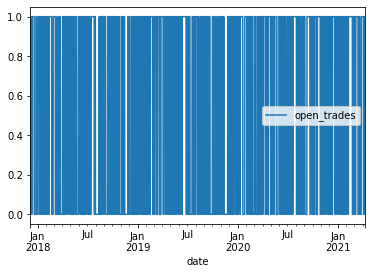

In [29]:
from freqtrade.data.btanalysis import analyze_trade_parallelism

# Analyze the above
parallel_trades = analyze_trade_parallelism(trades, '4h')

parallel_trades.plot()

In [30]:
from freqtrade.plot.plotting import  generate_candlestick_graph
# Limit graph period to keep plotly quick and reactive

# Filter trades to one pair
trades_red = trades.loc[trades['pair'] == pair]
data.set_index('date', drop=False)
data_red = data['2017-01-01':'2021-06-10']
# Generate candlestick graph
graph = generate_candlestick_graph(pair=pair,
                                   data=data_red,
                                   trades=trades_red,
                                   indicators1=['ema_fast', 'ema_slow', 'trail2','greenLine'],
                                   indicators2=['rsi']
                                  )

graph.show(renderer="browser")


In [31]:
 trades.loc[trades['pair'] == pair]

,pair,stake_amount,amount,open_date,close_date,open_rate,close_rate,fee_open,fee_close,trade_duration,...,sell_reason,initial_stop_loss_abs,initial_stop_loss_ratio,stop_loss_abs,stop_loss_ratio,min_rate,max_rate,is_open,open_timestamp,close_timestamp
0,BTC/USDT,0.05,0.00000432,2017-12-05 00:00:00+00:00,2017-12-08 12:00:00+00:00,11571.03,14849.99,0.001,0.001,5040,...,sell_signal,5785.515,-0.5,5785.515,-0.5,11571.03,17204.99,False,1.51243200e+12,1.51273440e+12
1,BTC/USDT,0.05,0.00000315,2017-12-09 00:00:00+00:00,2017-12-10 04:00:00+00:00,15880.01,12609.62,0.001,0.001,1680,...,sell_signal,7940.005,-0.5,7940.005,-0.5,13882.40,16269.30,False,1.51277760e+12,1.51287840e+12
2,BTC/USDT,0.05,0.00000324,2017-12-10 16:00:00+00:00,2017-12-14 08:00:00+00:00,15410.25,15756.70,0.001,0.001,5280,...,sell_signal,7705.125,-0.5,7705.125,-0.5,15410.25,17470.00,False,1.51292160e+12,1.51323840e+12
3,BTC/USDT,0.05,0.00000311,2017-12-14 12:00:00+00:00,2017-12-19 12:00:00+00:00,16098.95,17214.20,0.001,0.001,7200,...,sell_signal,8049.475,-0.5,8049.475,-0.5,16098.95,19798.68,False,1.51325280e+12,1.51368480e+12
4,BTC/USDT,0.05,0.00000350,2017-12-26 04:00:00+00:00,2017-12-28 08:00:00+00:00,14300.00,13984.38,0.001,0.001,3120,...,sell_signal,7150.000,-0.5,7150.000,-0.5,14300.00,16498.05,False,1.51426080e+12,1.51444800e+12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,BTC/USDT,0.05,0.00000101,2021-03-07 04:00:00+00:00,2021-03-15 08:00:00+00:00,49551.43,57789.75,0.001,0.001,11760,...,sell_signal,24775.715,-0.5,24775.715,-0.5,49551.43,61844.00,False,1.61508960e+12,1.61579520e+12
238,BTC/USDT,0.05,0.00000086,2021-03-17 20:00:00+00:00,2021-03-21 08:00:00+00:00,57867.42,56972.68,0.001,0.001,5040,...,sell_signal,28933.710,-0.5,28933.710,-0.5,57325.45,60129.97,False,1.61601120e+12,1.61631360e+12
239,BTC/USDT,0.05,0.00000091,2021-03-27 00:00:00+00:00,2021-04-04 00:00:00+00:00,55025.59,57051.95,0.001,0.001,11520,...,sell_signal,27512.795,-0.5,27512.795,-0.5,55025.59,60200.00,False,1.61680320e+12,1.61749440e+12
240,BTC/USDT,0.05,0.00000085,2021-04-05 20:00:00+00:00,2021-04-06 20:00:00+00:00,59005.21,58225.01,0.001,0.001,1440,...,sell_signal,29502.605,-0.5,29502.605,-0.5,58282.12,59495.24,False,1.61765280e+12,1.61773920e+12


In [32]:
trades

,pair,stake_amount,amount,open_date,close_date,open_rate,close_rate,fee_open,fee_close,trade_duration,...,sell_reason,initial_stop_loss_abs,initial_stop_loss_ratio,stop_loss_abs,stop_loss_ratio,min_rate,max_rate,is_open,open_timestamp,close_timestamp
0,BTC/USDT,0.05,0.00000432,2017-12-05 00:00:00+00:00,2017-12-08 12:00:00+00:00,11571.03,14849.99,0.001,0.001,5040,...,sell_signal,5785.515,-0.5,5785.515,-0.5,11571.03,17204.99,False,1.51243200e+12,1.51273440e+12
1,BTC/USDT,0.05,0.00000315,2017-12-09 00:00:00+00:00,2017-12-10 04:00:00+00:00,15880.01,12609.62,0.001,0.001,1680,...,sell_signal,7940.005,-0.5,7940.005,-0.5,13882.40,16269.30,False,1.51277760e+12,1.51287840e+12
2,BTC/USDT,0.05,0.00000324,2017-12-10 16:00:00+00:00,2017-12-14 08:00:00+00:00,15410.25,15756.70,0.001,0.001,5280,...,sell_signal,7705.125,-0.5,7705.125,-0.5,15410.25,17470.00,False,1.51292160e+12,1.51323840e+12
3,BTC/USDT,0.05,0.00000311,2017-12-14 12:00:00+00:00,2017-12-19 12:00:00+00:00,16098.95,17214.20,0.001,0.001,7200,...,sell_signal,8049.475,-0.5,8049.475,-0.5,16098.95,19798.68,False,1.51325280e+12,1.51368480e+12
4,BTC/USDT,0.05,0.00000350,2017-12-26 04:00:00+00:00,2017-12-28 08:00:00+00:00,14300.00,13984.38,0.001,0.001,3120,...,sell_signal,7150.000,-0.5,7150.000,-0.5,14300.00,16498.05,False,1.51426080e+12,1.51444800e+12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,BTC/USDT,0.05,0.00000101,2021-03-07 04:00:00+00:00,2021-03-15 08:00:00+00:00,49551.43,57789.75,0.001,0.001,11760,...,sell_signal,24775.715,-0.5,24775.715,-0.5,49551.43,61844.00,False,1.61508960e+12,1.61579520e+12
238,BTC/USDT,0.05,0.00000086,2021-03-17 20:00:00+00:00,2021-03-21 08:00:00+00:00,57867.42,56972.68,0.001,0.001,5040,...,sell_signal,28933.710,-0.5,28933.710,-0.5,57325.45,60129.97,False,1.61601120e+12,1.61631360e+12
239,BTC/USDT,0.05,0.00000091,2021-03-27 00:00:00+00:00,2021-04-04 00:00:00+00:00,55025.59,57051.95,0.001,0.001,11520,...,sell_signal,27512.795,-0.5,27512.795,-0.5,55025.59,60200.00,False,1.61680320e+12,1.61749440e+12
240,BTC/USDT,0.05,0.00000085,2021-04-05 20:00:00+00:00,2021-04-06 20:00:00+00:00,59005.21,58225.01,0.001,0.001,1440,...,sell_signal,29502.605,-0.5,29502.605,-0.5,58282.12,59495.24,False,1.61765280e+12,1.61773920e+12
